In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm

In [2]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
# organ = "BRAIN1"

# sex = 'male'
sex = 'female'

In [3]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/HEART.preprocessed.h5')

In [4]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [5]:
eval_organ = "BRAIN0"
eval_organ = "BRAIN1"
# eval_organ = 'HEART'
# eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [6]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000217939.7,ENST00000219919.9,ENST00000225328.10,ENST00000229270.8,ENST00000229384.5,ENST00000254090.9,ENST00000257359.7,ENST00000258646.3,ENST00000262483.13,ENST00000262816.11,...,MSTRG.8936.21,MSTRG.8962.2,MSTRG.8982.1,MSTRG.9001.7,MSTRG.9028.1,MSTRG.9324.5,MSTRG.9679.13,MSTRG.9771.2,MSTRG.9909.7,MSTRG.9947.1
SRR21423854,0.692847,0.169015,0.103467,0.620529,0.449301,0.652492,0.235829,0.039518,0.366129,1.098372,...,0.147480,1.418520,0.162945,0.317387,1.005056,0.283620,0.060140,0.077940,0.024850,0.653897
SRR21423855,1.053730,0.059224,0.089468,4.005813,0.405313,0.625610,0.877665,0.402099,0.088854,0.000000,...,0.203507,0.434382,0.011706,0.052873,0.401192,1.038025,0.024541,0.218144,0.187792,0.163202
SRR21423856,1.491178,0.267613,0.637205,0.181627,0.099189,0.871467,5.377368,0.586346,1.281584,0.178462,...,0.000000,0.105388,1.639669,0.104783,3.336985,0.496097,0.043006,0.271772,0.109342,1.887951
SRR21423857,2.628394,0.000000,0.815320,1.188072,1.366309,1.080534,3.654236,0.000385,1.188402,0.014098,...,0.255793,0.000000,1.595902,0.135547,0.648711,0.118269,0.023836,0.251996,2.661734,0.097166
SRR21423858,0.278420,0.225846,0.000000,4.960088,0.101330,0.928433,0.452067,1.851591,0.799651,0.505292,...,0.310206,2.727918,0.500730,0.101400,0.494459,0.000000,0.032660,0.444726,0.024961,0.827599
SRR21423859,0.653704,0.243602,0.476835,2.007073,0.162691,0.160169,0.815197,0.001605,0.237197,0.076539,...,0.089988,0.244740,0.512401,0.080516,0.291404,0.627915,0.006473,0.233410,0.515850,0.405636
SRR21423860,1.343977,2.378827,0.621828,3.847074,0.099150,0.289817,3.341295,0.651025,1.351555,0.093154,...,0.284223,0.026528,0.306837,0.270726,0.490611,0.048169,0.033190,0.895118,0.010526,0.272126
SRR21423861,0.267426,0.048613,0.432605,7.518103,0.476492,0.702371,0.417664,0.621421,0.217686,0.059208,...,0.252011,2.418016,0.849561,0.069026,0.366430,1.194101,0.012952,0.261506,0.799191,0.136523
SRR21423862,0.081404,0.077477,0.163545,0.371893,0.099220,0.397364,0.330789,0.000428,0.081949,0.339403,...,2.119527,1.966165,0.075975,0.052836,1.595356,0.333593,0.032624,0.116160,0.611691,3.317049
SRR21423863,0.809748,0.432016,0.127370,0.927013,0.096971,0.527667,0.509695,0.000324,1.482051,0.310217,...,0.115153,0.554210,0.920425,0.053505,0.604436,1.106647,3.412208,0.000000,0.066912,0.491464


In [7]:
# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values
y

SRR21423854    36
SRR21423855    36
SRR21423856    36
SRR21423857    36
SRR21423858    35
SRR21423859    39
SRR21423860    39
SRR21423861    26
SRR21423862    26
SRR21423863    26
SRR21423864    26
Name: Age, dtype: int64

In [8]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 1401/1401 [00:00<00:00, 1606.76it/s]


In [9]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [10]:
corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.3

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60],
 [Text(0, 0, 'ENST00000556476.1'),
  Text(1, 0, 'ENST00000554243.1'),
  Text(2, 0, 'ENST00000519878.1'),
  Text(3, 0, 'ENST00000372841.8'),
  Text(4, 0, 'ENST00000366529.4'),
  Text(5, 0, 'ENST00000524627.5'),
  Text(6, 0, 'ENST00000679970.1'),
  Text(7, 0, 'MSTRG.29296.55'),
  Text(8, 0, 'ENST00000466186.2'),
  Text(9, 0, 'MSTRG.11225.100'),
  Text(10, 0, 'ENST00000674645.1'),
  Text(11, 0, 'ENST00000361941.7'),
  Text(12, 0, 'ENST00000473696.1'),
  Text(13, 0, 'ENST00000462777.1'),
  Text(14, 0, 'ENST00000508301.5'),
  Text(15, 0, 'ENST00000262963.11'),
  Text(16, 0, 'ENST00000624362.2'),
  Text(17, 0, 'MSTRG.19863.17'),
  Text(18, 0

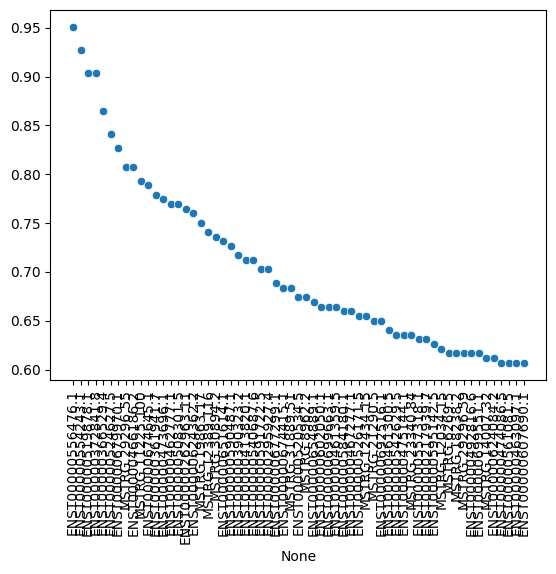

In [11]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [12]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
        'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
        'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000466186.2',
        'MSTRG.11225.100', 'ENST00000674645.1', 'ENST00000361941.7',
        'ENST00000473696.1', 'ENST00000462777.1', 'ENST00000508301.5',
        'ENST00000262963.11', 'ENST00000624362.2', 'MSTRG.19863.17',
        'MSTRG.12389.116', 'MSTRG.30894.2', 'ENST00000651614.1',
        'ENST00000590487.1', 'ENST00000390323.2', 'ENST00000413820.1',
        'ENST00000540687.6', 'ENST00000591722.5', 'ENST00000295927.4',
        'ENST00000677299.1', 'ENST00000674415.1', 'MSTRG.31889.51',
        'ENST00000520534.5', 'MSTRG.8962.2', 'ENST00000654889.1',
        'ENST00000602050.1', 'ENST00000699663.1', 'ENST00000461359.5',
        'ENST00000584180.1', 'ENST00000467277.1', 'ENST00000526171.5',
        'MSTRG.12434.15', 'MSTRG.21290.5', 'ENST00000692516.1',
        'ENST00000461300.5', 'ENST

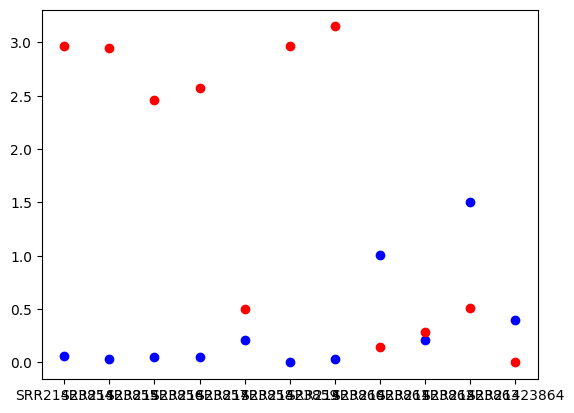

In [13]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [14]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR21423854    0.063602
SRR21423855    0.031257
SRR21423856    0.049235
SRR21423857    0.055494
SRR21423858    0.208461
SRR21423859    0.000000
SRR21423860    0.030677
SRR21423861    1.004368
SRR21423862    0.211603
SRR21423863    1.506039
SRR21423864    0.394979
Name: ENST00000556476.1, dtype: float32

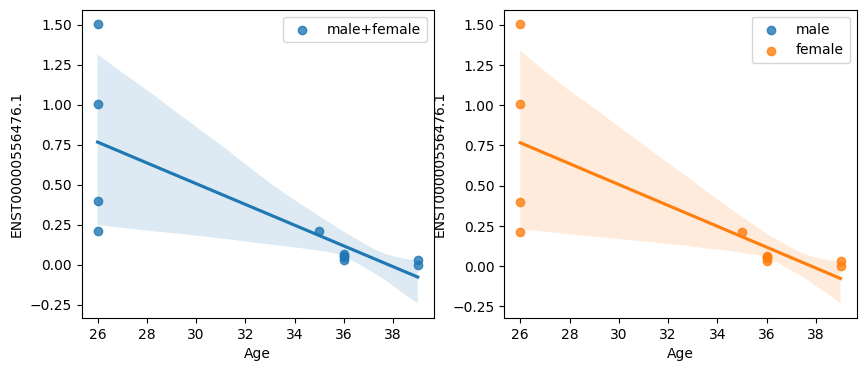

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE

# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 11])):

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")

    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        train_scaler = RobustScaler().fit(X_train)
        test_scaler = RobustScaler().fit(X_test)
        X_train = train_scaler.transform(X_train)
        X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test

        model = svm.SVR(kernel='linear')
        # model = LinearRegression()
        # model = XGBRegressor()
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_test)
        
        preds.append(pred)
        vals.append(y_val)
        
        X_train_ = sm.add_constant(X_train_)
        X_test = sm.add_constant(X_test, has_constant='add')
        
        mod = sm.GLS(y_train_, X_train_).fit()
        gls_pred = mod.predict(X_test)
        gls_preds.append(gls_pred)

    print("RMSE: ", RMSE(preds, vals))
    print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    print("R2: ", r2_score(vals, gls_preds))
    print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

11
n_features=1


11it [00:00, 629.96it/s]


RMSE:  6.210802031288341
RMSE:  6.212506482814832
R2:  -0.37927348891681456
R2:  -0.38003063022487416
Index(['ENST00000556476.1'], dtype='object')
--------------------
n_features=2


11it [00:00, 542.35it/s]


RMSE:  6.316724865093043
RMSE:  6.947999558649183
R2:  -0.42672061925988536
R2:  -0.7261342913432918
Index(['ENST00000556476.1', 'ENST00000554243.1'], dtype='object')
--------------------
n_features=3


11it [00:00, 532.75it/s]


RMSE:  6.281142278553101
RMSE:  6.688808080193676
R2:  -0.41069224206108035
R2:  -0.5997513527108063
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1'], dtype='object')
--------------------
n_features=4


11it [00:00, 494.54it/s]


RMSE:  6.306740114951119
RMSE:  6.135205955421484
R2:  -0.42221379319786445
R2:  -0.3459015975083184
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8'],
      dtype='object')
--------------------
n_features=5


11it [00:00, 473.31it/s]


RMSE:  6.232463576234228
RMSE:  6.129236772792079
R2:  -0.3889113090187495
R2:  -0.3432839105941332
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4'],
      dtype='object')
--------------------
n_features=6


11it [00:00, 450.03it/s]


RMSE:  6.231447819702328
RMSE:  6.070116175779207
R2:  -0.3884586210078078
R2:  -0.3174951409226423
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5'],
      dtype='object')
--------------------
n_features=7


11it [00:00, 435.41it/s]


RMSE:  6.187667328396021
RMSE:  6.11180720229355
R2:  -0.36901727629871317
R2:  -0.33565504155995396
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
       'ENST00000679970.1'],
      dtype='object')
--------------------
n_features=8


11it [00:00, 413.13it/s]


RMSE:  6.437725597431517
RMSE:  6.697959574571666
R2:  -0.4819035505339311
R2:  -0.6041318433729748
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
       'ENST00000679970.1', 'MSTRG.29296.55'],
      dtype='object')
--------------------
n_features=9


11it [00:00, 385.20it/s]


RMSE:  6.396240568945476
RMSE:  7.23912197959316
R2:  -0.4628661652821209
R2:  -0.8738154052266207
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
       'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000466186.2'],
      dtype='object')
--------------------
n_features=10


11it [00:00, 258.20it/s]

RMSE:  6.374782491113227
RMSE:  6.2254349905635396
R2:  -0.4530673962439291
R2:  -0.38578041945321373
Index(['ENST00000556476.1', 'ENST00000554243.1', 'ENST00000519878.1',
       'ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
       'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000466186.2',
       'MSTRG.11225.100'],
      dtype='object')
--------------------


In [27]:
n_features = 7

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

X_total = X
X_total = RobustScaler().fit_transform(X)

model.fit(X_total, y)
pred = model.predict(X_total)
print(pred)


mod = sm.GLS(y, sm.add_constant(X_total)).fit()
gls_pred = mod.predict(sm.add_constant(X_total))
print(gls_pred)

print("RMSE: ", RMSE(y, pred))
print("RMSE: ", RMSE(y, gls_pred))

print("-"*20)

X_eval = data_eval[data.columns[sorted_corr_ids[:n_features]]]
# X_eval = RobustScaler().fit_transform(X_eval)

y_predicted = model.predict(X_eval)
# print(y_predicted.astype(int), data_eval_header['Age'].values)
# 
y_pred_gls = mod.predict(sm.add_constant(X_eval))
# print(y_pred_gls.astype(int), data_eval_header['Age'].values)

print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_predicted))
print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_pred_gls))


print("R2: ", r2_score(data_eval_header['Age'].values, y_predicted))
print("R2: ", r2_score(data_eval_header['Age'].values, y_pred_gls))

# y_predicted = mod.predict(sm.add_constant(X_eval))

[37.07591725 36.09944861 36.24293977 35.67540739 33.2985003  38.89998097
 37.54687824 26.10033944 25.90033885 25.89989275 29.48301111]
[36.3832467  35.81805185 36.93822671 36.04013216 34.61979205 39.37538601
 37.75448099 26.17720089 26.00336672 25.92356179 25.96655414]
RMSE:  1.2971971239443894
RMSE:  0.5167227475410744
--------------------
RMSE eval:  13.689031665246047
RMSE eval:  24.957222542398636
R2:  -0.6532418906495445
R2:  -4.49519930141614


/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [18]:
X


array([[6.3602284e-02, 2.9626904e+00, 2.0379126e-01, 2.7121893e-01,
        3.5715786e-01, 5.7572205e-02, 3.7871027e+00, 1.6172554e-02,
        6.2930524e-01, 2.7615237e-01],
       [3.1256799e-02, 2.9480729e+00, 2.1571961e-01, 2.3898369e-01,
        7.1528369e-01, 1.3287912e-02, 8.3647802e-02, 1.8622495e+00,
        6.9714606e-02, 2.3890179e-01],
       [4.9234860e-02, 2.4608250e+00, 2.3348804e-01, 9.3792789e-02,
        4.9893194e-01, 3.0265361e-02, 8.4443964e-02, 1.9229772e+00,
        3.5994494e-01, 6.4158112e-01],
       [5.5494115e-02, 2.5703204e+00, 1.8276986e-01, 4.2757079e-01,
        1.7954163e-01, 3.7096806e-02, 3.4474909e-02, 9.9155150e-02,
        1.7574552e-01, 1.2199016e-01],
       [2.0846106e-01, 5.0327450e-01, 2.0388892e-01, 8.1595492e-01,
        1.2031598e+00, 1.5051027e-01, 2.7410306e-02, 1.2307943e-01,
        4.0487058e-02, 5.3423595e-01],
       [0.0000000e+00, 2.9703789e+00, 0.0000000e+00, 3.3148728e-02,
        2.8118181e-01, 1.0093698e-02, 4.9248867e+00, 3.02

In [19]:
X_eval

,ENST00000556476.1,ENST00000554243.1,ENST00000519878.1,ENST00000372841.8,ENST00000366529.4,ENST00000524627.5,ENST00000679970.1,MSTRG.29296.55,ENST00000466186.2,MSTRG.11225.100
Run,,,,,,,,,,
SRR19147434,1.789040,0.542750,0.321237,1.963133,3.308889,0.000000,4.565634,0.060746,0.019883,1.481967
SRR19147442,1.147282,1.526536,0.634025,1.773491,1.275225,0.120372,2.736798,0.281212,0.108565,1.263135
SRR19147446,1.750530,0.499723,0.384707,0.000000,3.259892,0.139725,3.433445,0.143097,0.052444,0.761679
SRR19147447,1.466845,1.237093,0.752637,0.097752,4.563422,0.115431,3.846098,0.000881,0.033560,1.934923
SRR19147449,1.486527,1.812405,0.258097,0.501456,3.363263,0.068356,2.015157,0.143056,0.115711,1.105106
...,...,...,...,...,...,...,...,...,...,...
SRR19147639,0.507326,0.891029,0.511750,0.575613,1.660926,0.241902,3.299588,0.225571,0.311464,0.757225
SRR19147640,1.102413,0.854308,0.653310,1.099882,4.243175,0.639654,2.386466,0.035773,0.407448,0.758468
SRR19147643,0.212868,0.442806,0.572430,1.145456,3.784542,0.111695,1.960253,0.030387,0.087414,1.111039
